# Stock Trading Strategy Backtesting

**Author**: Long Shangshang (Cheryl)

**Date**: December 15,2016

**Summary**: Test a trading system based on market trend signals. Does technical analysis really work?

**Description**: Technical analysis is a security analysis methodology for forecasting the direction of	prices through the study of past market data, primarily price and volume. Many financial professionals and interested amateurs apply technical analysis to stock investments. They predict future price trends and develop trading strategies using historical market data.In this project, I am going to test the performance of an investment strategy based on trading signals generated by two-month and one-year trend lines. 

**Outline**:
* [Download data](#Download-data): get the daily closing quotes data for S&P 500 index
* [Clean data](#Clean-data): observe the historical market trend 
* [Generate trend lines](#Generate-trend-lines): develop the two-month and one-year trend lines 
* [Generate trading signals](#Generate-trading-signals): form the trading signals based on a rule
* [Backtest the strategy](#Does-the-trading-strategy-perform-well-?): see if the strategy outperforms the market

This Jupyter notebook was created with a lot of help from Spencer Lyon and Chase Coleman for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objs as go 

%matplotlib inline
init_notebook_mode(connected=True)

## Download data

This project will use the historical daily closing quotes data for S&P 500 index from January 3,2000 to December 9,2016, which can be found on [Quandl](https://www.quandl.com/) at this [link](https://www.quandl.com/data/YAHOO/INDEX_GSPC-S-P-500-Index). S&P 500 index is generally considered to be a good proxy for the whole stock market in the United States. Quandl provides an API which can be used to download the data.

* API:  YAHOO/INDEX_GSPC
* Parameters:
  - start_date: Specified in format  `year-month-day`
  - end_date: Specified in format  `year-month-day`

**Note**:  The Quandl Python package should be installed already. If not, enter 
```pip install quandl 
``` from the command line (command prompt on windows, terminal on mac) to install it.

In [2]:
import quandl
sp500=quandl.get("YAHOO/INDEX_GSPC",start_date="2000-01-03",end_date="2016-12-09")
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4263 entries, 2000-01-03 to 2016-12-09
Data columns (total 6 columns):
Open              4263 non-null float64
High              4263 non-null float64
Low               4263 non-null float64
Close             4263 non-null float64
Volume            4263 non-null float64
Adjusted Close    4263 non-null float64
dtypes: float64(6)
memory usage: 233.1 KB


In [3]:
sp500.head()

,Open,High,Low,Close,Volume,Adjusted Close
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,9.318000e+08,1455.219971
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1.009000e+09,1399.420044
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1.085500e+09,1402.109985
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1.092300e+09,1403.449951
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1.225200e+09,1441.469971


In [4]:
type(sp500.index)

pandas.tseries.index.DatetimeIndex

## Clean data
The time series data for the S&P 500 index is now in the dataframe `sp500` which automatically has index as `datetime` objects. I will keep data in the column `Close` and drop any other data that this project is not going to use. 

In [5]:
sp500=sp500.drop(['Open','High','Low','Volume','Adjusted Close'],axis=1)
sp500.head()

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971


Plot the closing quotes over time to get a fisrt impression about the historical market trend by using [plotly](https://plot.ly/python/) package. In the following graph, not only can you observe the trend from the start date to the end date but also use the range selectors in the upper left corner and the range slider at the bottom to see the trend in a specific period of time. 

In [6]:
trace = go.Scatter(x=sp500.index,
                   y=sp500['Close'])
data=[trace]

layout = dict(
    width=1000,
    height=600,
    title='Historical levels of the S&P 500 index',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(count=5,
                    label='5y',
                    step='year',
                    stepmode='backward'),
                dict(count=10,
                    label='10y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)
fig = dict(data=data, layout=layout)
iplot(fig)

## Generate trend lines
The trading strategy I am going to test is based on both a two-month(i.e., 42 trading days) trend line and a one-year(i.e., 252 trading days) trend line. Trend line is formed of the moving average of the index level for the corresponding time period. To generate the two kinds of trend lines, first, the data of moving average of the S&P 500 index in respective period should be calculated. Two new columns are added to the dataframe `sp500`, the column `42d` contains values for the 42-day trend and the column `252d` contains the 252-day trend data. 

In [7]:
sp500['42d']=sp500['Close'].rolling(window=42).mean()
sp500['252d']=sp500['Close'].rolling(window=252).mean()
sp500.tail()

,Close,42d,252d
Date,,,
2016-12-05,2204.709961,2156.772839,2079.868845
2016-12-06,2212.229980,2157.998076,2080.405194
2016-12-07,2241.350098,2160.084031,2081.110591
2016-12-08,2246.189941,2162.049032,2081.898567
2016-12-09,2259.530029,2164.972842,2082.721186


Notice that these two new columns have fewer entries because they start having data only when 42 and 252 observation points, respectively, are available for the first time to calculate the moving average. Then, plot these two trend lines in a single figure with the historical level of S&P 500 index. You can still use the range selectors and the range slider to observe a certain period. Also, a trend line will disappear if you click on the corresponding legend in the upper right corner of the graph. This function makes it easier to get some insights from those upward and downward trends. 


In [8]:
trace1 = go.Scatter(x=sp500.index,
                    y=sp500['Close'],
                    name='close')
trace2 = go.Scatter(x=sp500.index,
                    y=sp500['42d'],
                    name='42d')
trace3 = go.Scatter(x=sp500.index,
                    y=sp500['252d'],
                    name='252d')

data=[trace1,trace2,trace3]

layout = dict(
    width=1000,
    height=600,
    title='The S&P 500 index with 42-day and 252-day trend lines ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(count=5,
                    label='5y',
                    step='year',
                    stepmode='backward'),
                dict(count=10,
                    label='10y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)
fig = dict(data=data, layout=layout)
iplot(fig)

## Generate trading signals
The stock investment strategy which is going to be tested is based on trading signals generated by the 42-day and 252-day trends created above. The following rule generates trading signals:
* Buy: when the 42-day trend is for the first time 50 points above the 252-day trend
* Wait: when the 42-day trend is within a range of +/- 50 points around the 252-day trend
* Sell: when the 42-day trend is for the first time 50 points below the 252-day trend

In this project, it is assumed that an invester can directly buy or sell the S&P 500 index. The transaction costs will be caused in the real market is not considered here. 



In [9]:
sp500['42-252']=sp500['42d']-sp500['252d']
sp500['42-252'].tail()

Date
2016-12-05    76.903994
2016-12-06    77.592882
2016-12-07    78.973440
2016-12-08    80.150465
2016-12-09    82.251656
Name: 42-252, dtype: float64

After the differences between the 42-day trend and the 252-day trend being calculated, the trading signals are generated according to the rule. The signal `"1"` means to have long positions in the index and get the market returns. The signal `"0"` means not to buy or sell the index and make no returns. The signal `"-1"` means to go short on the index and get the negative market returns. 

In [10]:
sp500['Signal']=np.where(sp500['42-252']>50,1,0)
sp500['Signal']=np.where(sp500['42-252']<-50,-1,sp500['Signal'])
sp500['Signal'].value_counts()

 1    1935
 0    1378
-1     950
Name: Signal, dtype: int64

The result shows that from January 3,2000 to December 9,2016, there were 1935 trading days when the 42-day trend was more than 50 points above the 252-day trend. On 950 trading days, the 42-day trend lies more than 50 points below the 252-day trend. The change of signals over time can be seen in the following graph.

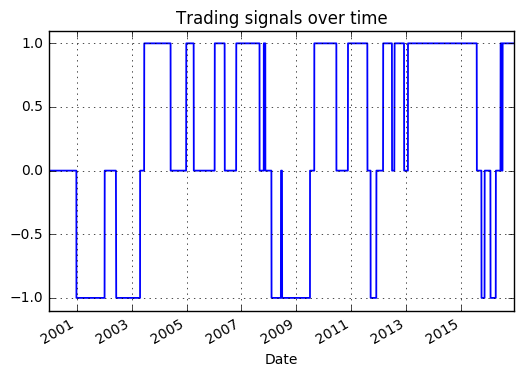

In [11]:
figure,ax=plt.subplots()
sp500['Signal'].plot(ax=ax,lw=1.3,fontsize=10,
                     ylim=[-1.1,1.1],
                     title='Trading signals over time',
                     grid=True)

## Does the trading strategy perform well?
Test the performance of the investment strategy based on trading signals generated above by comparing the cumulative,continuous market returns with the cumulative, continuous returns made by the strategy. Daily log returns are calculated here.


In [12]:
sp500['Market returns']=np.log(sp500['Close']/sp500['Close'].shift(1))
sp500['Strategy returns']=sp500['Signal'].shift(1)*sp500['Market returns']
sp500[['Market returns','Strategy returns']].cumsum().apply(np.exp).tail()

,Market returns,Strategy returns
Date,,
2016-12-05,1.515036,2.525388
2016-12-06,1.520203,2.534002
2016-12-07,1.540214,2.567358
2016-12-08,1.543540,2.572902
2016-12-09,1.552707,2.588182


Plot the market returns and the returns of the strategy over time to see the performance of the trading strategy constructed on trend lines. As before, You can use the range selectors and the range slider to check whether the strategy works well in a certain period of time. 

In [13]:
return1 = go.Scatter(x=sp500.index,
                    y=sp500['Market returns'].cumsum().apply(np.exp),
                    name='Market')
return2 = go.Scatter(x=sp500.index,
                    y=sp500['Strategy returns'].cumsum().apply(np.exp),
                    name='Strategy')

data=[return1,return2]

layout = dict(
    width=1000,
    height=600,
    title='The market returns vs the strategy returns ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(count=5,
                    label='5y',
                    step='year',
                    stepmode='backward'),
                dict(count=10,
                    label='10y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)
fig = dict(data=data, layout=layout)
iplot(fig)

This graph shows that the trading strategy pays off well and outperforms the market especially during bearish periods. For example, In year 2008 and 2009, when the index dropped drastically, selling the index generated quite high returns. Although the returns of the strategy sometimes go down during bullish periods, on the whole, the trading strategy performs better than the market. 

But in this project, many factors that doubtlessly have an impact on the performance of the strategy are neglected for simplicity such as transaction costs and the proper time to execution. However, the overall conclusion would possibly persist because the strategy doesn't trade very frequently according to the trading signals.